In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from time import time
import librosa
import librosa.display

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def graph_mel_spectogram(wav_file):
    y, sr = librosa.load(wav_file, sr=44100)
    activation, _ = librosa.effects.trim(y)
    n_fft = 2048
    hop_length = 512
    n_mels = 128
    S = librosa.feature.melspectrogram(activation, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    #plt.colorbar(format='%+2.0f dB');
    return S_DB

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("raw_data/COMBINED_ACTIVATIONS"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("raw_data/COMBINED_ACTIVATIONS/"+filename)
            activates.append(activate)
    for filename in os.listdir("raw_data/COMBINED_BACKGROUNDS"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("raw_data/COMBINED_BACKGROUNDS/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("raw_data/COMBINED_NEGATIVES"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("raw_data/COMBINED_NEGATIVES/"+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

def convert_and_save(input_path, output_path):
    existing_files, converted_files = [], []
    max_idx = 0
    
    if not os.path.isdir(input_path):
        print(f"[ERROR] There is no input path directory: {input_path}")
        return
    
    if not os.path.isdir(output_path):
        print(f"[ERROR] There is no output path directory: {output_path}")
        return
    
    for filename in os.listdir(output_path):
        if filename.endswith("wav"):
            existing_files.append(filename)
            if max_idx < int(filename[:-4]):
                max_idx = int(filename[:-4])
    print(f"[INFO] Last file in {output_path} is {max_idx}.wav")
    
    current_idx = 1
    for filename in os.listdir(input_path):
        if filename.endswith("mp3"):
            sound = AudioSegment.from_mp3(f"{input_path}/{filename}")
            sound = sound.set_frame_rate(44100)
            sound.export(f"{output_path}/{str(max_idx + current_idx)}.wav", format="wav")
            current_idx += 1
    print(f"[INFO] Files from {input_path} were converted and saved to {output_path}. Current amount of files is {str(current_idx + max_idx)}.")

In [4]:
#convert_and_save("raw_data/positive_LISTEN_COMRADE", "raw_data/COMBINED_ACTIVATIONS")

In [5]:
Tx = 862
Ty = int((Tx - 15)/4 + 1)
n_freq = 128

# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
1296 

activate[1] len: different `activate` clips can have different lengths
1000 



In [6]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [7]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        # I'll add some additional space after the end of the previous segment to prevent too close activations in training examples
        if segment_start <= previous_end + 400 and segment_start >= previous_start - 400 :
            overlap = True
    return overlap

In [8]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment!!! onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [9]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 11):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [10]:
def create_training_example(background, activates, negatives, counter, path, type_):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    #np.random.seed(18)
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as an empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(1, 3)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(1, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    idx = str(counter)
    file_handle = background.export(path + "/" + type_ + idx + ".wav", format="wav")
    print(f"File ({type_}{idx}.wav) was saved in {path}.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    #x = graph_spectrogram(path + "/" + type_ + idx + ".wav")
    x = graph_mel_spectogram(path + "/" + type_ + idx + ".wav")
    return x, y

In [11]:
import os.path

def generate_dataset(amount, Tx, Ty, n_freq, type_, path, save, delete_previous):
    dataset_name = f'X_{type_}.npy'
    dataset_Y_name = f'Y_{type_}.npy'
    exists = os.path.isfile(dataset_name)
    
    if exists and delete_previous:
        print(f"[INFO] Deleting previous X_{type_}.npy and Y_{type_}.npy.")
        os.remove(dataset_name)
        os.remove(dataset_Y_name)
        print(f"[INFO] Previous X_{type_}.npy and Y_{type_}.npy were deleted.")
        exists = os.path.isfile(dataset_name)
    
    if not exists:
        print(f"[INFO] Creating  X_{type_}, Y_{type_}")
        X, Y = np.zeros((amount, Tx, n_freq)), np.zeros((amount, Ty, 1))
        for i in range(0, amount):
            idx = np.random.randint(low=0, high=len(backgrounds))
            X_tmp, Y_tmp = create_training_example(backgrounds[idx], activates, negatives, i, path, type_)
            #!!!
            #if X_tmp.shape[1] > Tx:
            #    X_tmp = X_tmp[:, :Tx]
            #!!!
            if X_tmp.shape != (128, 431):
                #print(X_tmp.shape)
                X_tmp = np.pad(X_tmp, [(0, 0), (0, Tx - X_tmp.shape[1])], mode='constant', constant_values=0)
            X[i], Y[i] = X_tmp.swapaxes(0,1), Y_tmp.swapaxes(0,1)
    else:
        print("[INFO] Dataset exists")
        X, Y = np.load(f'X_{type_}.npy'), np.load(f'Y_{type_}.npy')
        print("[INFO] Dataset loaded")
        
    if save:
        if not exists:
            print("[INFO] Saving dataset")
            np.save(f'X_{type_}.npy', X)
            np.save(f'Y_{type_}.npy', Y)
        else:
            print("[INFO] Dataset already exists")

File (example0.wav) was saved in /home/biowar/handson-ml2/MyFiles.


/home/biowar/anaconda3/envs/ML/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/biowar/anaconda3/envs/ML/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


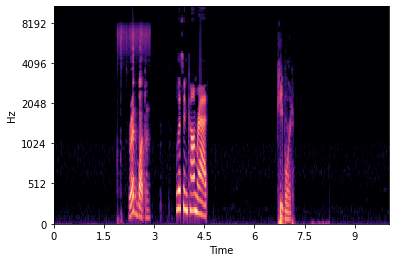

In [12]:
x_example, y_example = create_training_example(backgrounds[50], activates, negatives, 0, "/home/biowar/handson-ml2/MyFiles", "example")

In [13]:
x_example.shape

(128, 862)

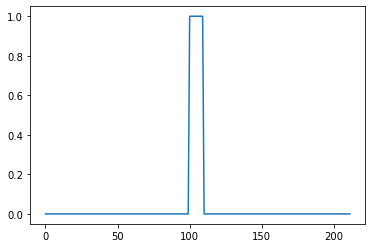

In [14]:
plt.plot(y_example[0])
filename = f"/home/biowar/handson-ml2/MyFiles/example0.wav"
IPython.display.Audio(filename)

In [ ]:
path = "TRAIN_MEL3"
generate_dataset(amount=3072, Tx=Tx, Ty=Ty, n_freq=n_freq, type_="train3_mel", path=path, save=True, delete_previous=True)

[INFO] Creating  X_train3_mel, Y_train3_mel
File (train3_mel0.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.


/home/biowar/anaconda3/envs/ML/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/biowar/anaconda3/envs/ML/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


File (train3_mel1.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel2.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel3.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel4.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel5.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel6.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel7.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel8.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel9.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel10.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel11.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel12.wav) was saved in /home/biowar/handson-ml2/MyFiles/TRAIN_MEL3.
File (train3_mel13.wav) w

In [ ]:
wav_file = "train0.wav"
graph_spectrogram(f"{path}/{wav_file}")
IPython.display.Audio(f"{path}/{wav_file}")

# Model evaluation

In [3]:
path = "model-rnn-comrade-44100-mel.v4.h5"
model = keras.models.load_model(path)

In [4]:
import numpy as np
X_dev, Y_dev = np.load(f'X_dev_mel.npy'), np.load(f'Y_dev_mel.npy')

In [22]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

4/4 [==============================] - 0s 63ms/step - loss: 0.5662 - accuracy: 0.9087
Dev set accuracy =  0.90874183177948


In [7]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

4/4 [==============================] - 0s 122ms/step - loss: 0.4740 - accuracy: 0.9316
Dev set accuracy =  0.9316436648368835


In [9]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

4/4 [==============================] - 0s 78ms/step - loss: 0.4697 - accuracy: 0.9305
Dev set accuracy =  0.9304800033569336


In [6]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

4/4 [==============================] - 0s 57ms/step - loss: 0.4684 - accuracy: 0.9307
Dev set accuracy =  0.9306763410568237


In [15]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

8/8 [==============================] - 0s 10ms/step - loss: 0.2820 - accuracy: 0.9538
Dev set accuracy =  0.9538318514823914


In [6]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

8/8 [==============================] - 0s 9ms/step - loss: 0.2240 - accuracy: 0.9698
Dev set accuracy =  0.9697916507720947


In [19]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

16/16 [==============================] - 0s 17ms/step - loss: 0.3150 - accuracy: 0.9636
Dev set accuracy =  0.9636000394821167


In [5]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

16/16 [==============================] - 0s 17ms/step - loss: 0.2932 - accuracy: 0.9696
Dev set accuracy =  0.9695515036582947


In [5]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

16/16 [==============================] - 0s 17ms/step - loss: 0.2704 - accuracy: 0.9711
Dev set accuracy =  0.9710992574691772
